In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb



 **Data Preprocessing**

In [2]:
df = pd.read_csv("customer_churn.csv")
df.drop('customerID', axis='columns', inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df[df.TotalCharges != ' ']
df.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
952,Male,0,No,No,22,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Mailed check,55.1,1253.15,No
4070,Male,1,Yes,No,55,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.0,4052.40,No
893,Female,0,No,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,24.6,24.60,Yes
5651,Female,0,Yes,No,42,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,Yes,Electronic check,84.3,3588.40,Yes
1608,Male,0,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,20.1,279.50,No


**Replace special values with 'No'**

In [3]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

**Convert categorical columns to binary values (Yes/No to 1/0)**

In [4]:
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                  'StreamingMovies', 'PaperlessBilling', 'Churn']
df[yes_no_columns] = df[yes_no_columns].replace({'Yes': 1, 'No': 0})

C:\Users\varan\AppData\Local\Temp\ipykernel_27852\2569310507.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[yes_no_columns] = df[yes_no_columns].replace({'Yes': 1, 'No': 0})


**Gender encoding (Female: 1, Male: 0)**

In [5]:
df['gender'].replace({'Female': 1, 'Male': 0}, inplace=True)

C:\Users\varan\AppData\Local\Temp\ipykernel_27852\2183267784.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gender'].replace({'Female': 1, 'Male': 0}, inplace=True)
C:\Users\varan\AppData\Local\Temp\ipykernel_27852\2183267784.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'].

**One-hot encoding for categorical columns**

In [6]:
df2 = pd.get_dummies(data=df, columns=['InternetService', 'Contract', 'PaymentMethod'])

**Scaling numeric columns**

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [8]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,1,0,1,1,0,0,0,DSL,1,0,1,1,1,0,Two year,1,Bank transfer (automatic),52.55,NaN,0
753,0,0,0,1,0,1,0,No,0,0,0,0,0,0,Two year,0,Mailed check,20.25,NaN,0
936,1,0,1,1,0,1,0,DSL,1,1,1,0,1,1,Two year,0,Mailed check,80.85,NaN,0
1082,0,0,1,1,0,1,1,No,0,0,0,0,0,0,Two year,0,Mailed check,25.75,NaN,0
1340,1,0,1,1,0,0,0,DSL,1,1,1,1,1,0,Two year,0,Credit card (automatic),56.05,NaN,0
3331,0,0,1,1,0,1,0,No,0,0,0,0,0,0,Two year,0,Mailed check,19.85,NaN,0
3826,0,0,1,1,0,1,1,No,0,0,0,0,0,0,Two year,0,Mailed check,25.35,NaN,0
4380,1,0,1,1,0,1,0,No,0,0,0,0,0,0,Two year,0,Mailed check,20.00,NaN,0
5218,0,0,1,1,0,1,0,No,0,0,0,0,0,0,One year,1,Mailed check,19.70,NaN,0
6670,1,0,1,1,0,1,1,DSL,0,1,1,1,1,0,Two year,0,Mailed check,73.35,NaN,0


**Data Visualizations**

Churn vs Tenure

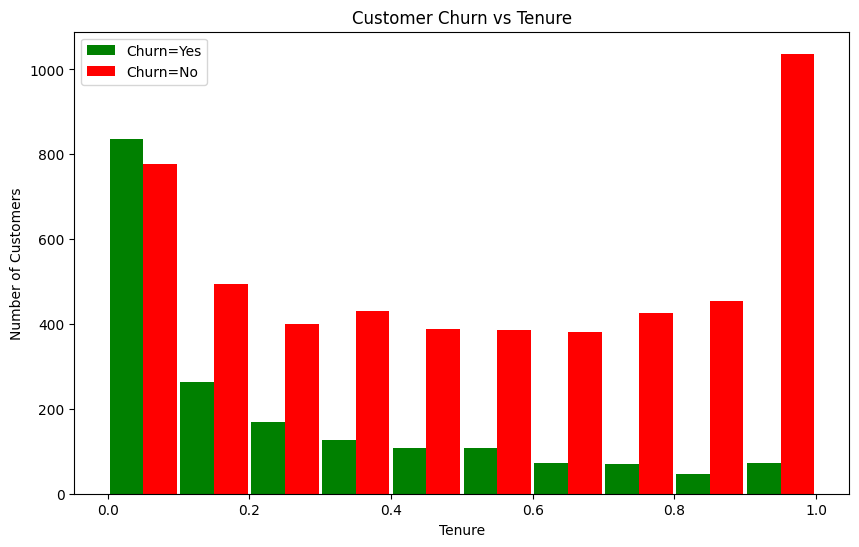

In [9]:
tenure_churn_no = df2[df2.Churn == 0].tenure
tenure_churn_yes = df2[df2.Churn == 1].tenure

plt.figure(figsize=(10, 6))
plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn=Yes', 'Churn=No'])
plt.xlabel("Tenure")
plt.ylabel("Number of Customers")
plt.title("Customer Churn vs Tenure")
plt.legend()
plt.show()

Churn vs Monthly Charges

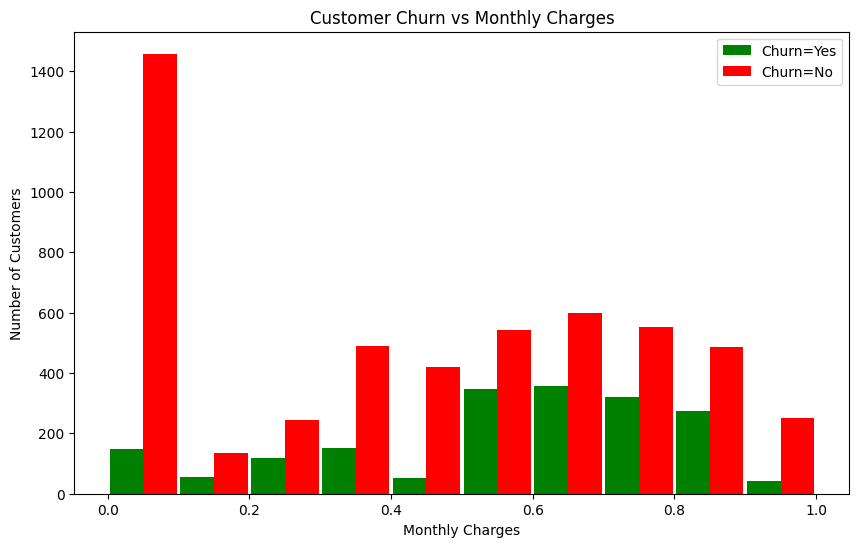

In [10]:
mc_churn_no = df2[df2.Churn == 0].MonthlyCharges
mc_churn_yes = df2[df2.Churn == 1].MonthlyCharges

plt.figure(figsize=(10, 6))
plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn=Yes', 'Churn=No'])
plt.xlabel("Monthly Charges")
plt.ylabel("Number of Customers")
plt.title("Customer Churn vs Monthly Charges")
plt.legend()
plt.show()

**Correlation Heatmap**

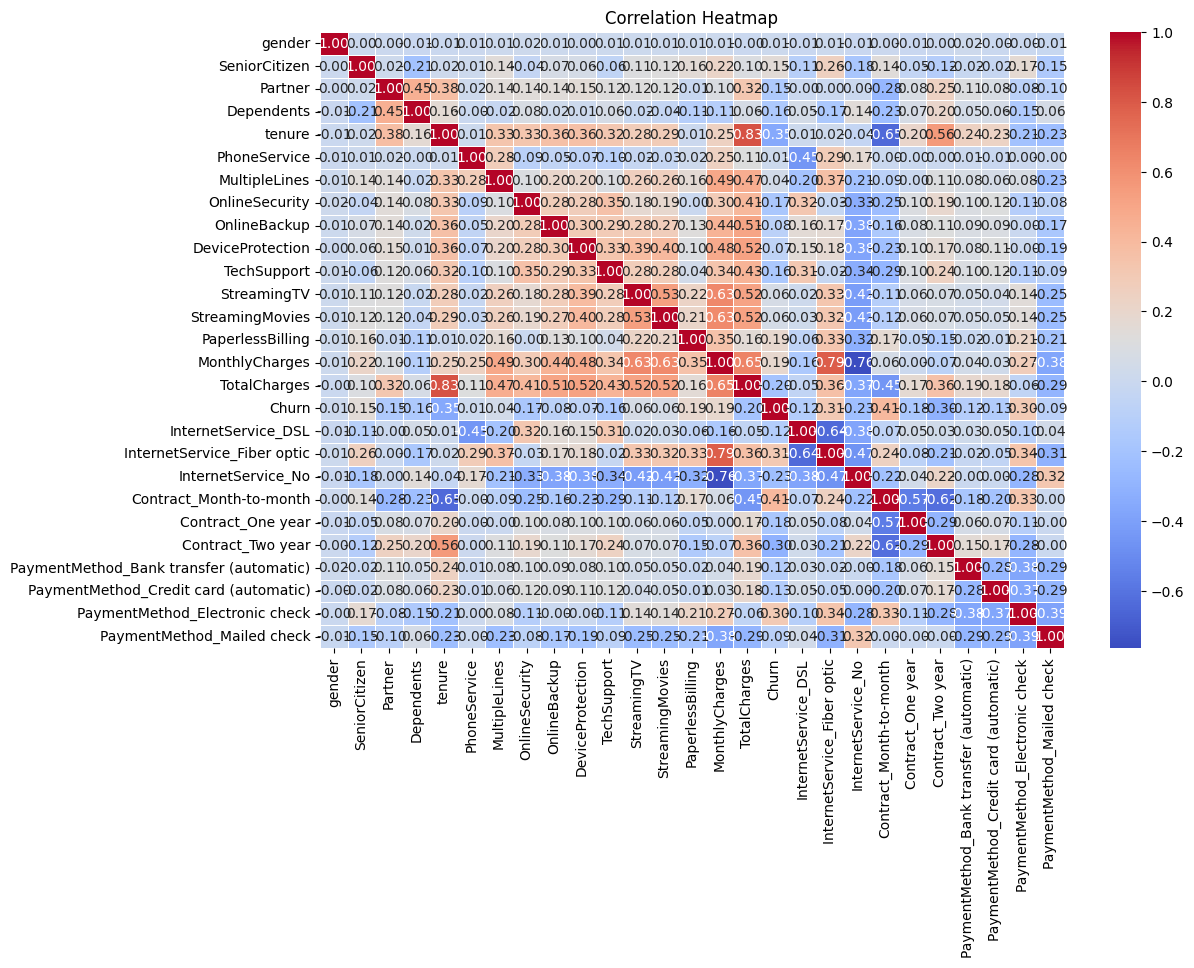

In [11]:
df2.replace('No phone service', np.nan, inplace=True)
df2 = df2.apply(pd.to_numeric, errors='coerce')
corr = df2.corr()
plt.figure(figsize=(12, 8))
sn.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


**Train-test split**

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df2.drop('Churn', axis='columns')
y = df2['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5, stratify=y)

# Fill missing values with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Apply SMOTE on training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_res))

After SMOTE: Counter({1: 4139, 0: 4139})


**ANN Model**

In [13]:
model_ann = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ann.fit(X_train_res, y_train_res, epochs=100)

# Save the trained ANN model
model_ann.save("ann_model.h5")


C:\Users\varan\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.7025 - loss: 0.5755
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7858 - loss: 0.4639
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7844 - loss: 0.4678
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7912 - loss: 0.4480
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7940 - loss: 0.4472   
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7957 - loss: 0.4439
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.4405
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8022 - loss: 0.4303
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.8025 - loss: 0.4265
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.8102 - loss: 0.4213
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.8112 - loss: 0.4141
Epoch 12/100
259/259 ━

**ANN Evaluation**

In [14]:
ann_accuracy = model_ann.evaluate(X_test, y_test, verbose=0)[1]

**XGBoost Model**

In [15]:
from sklearn.model_selection import RandomizedSearchCV
import joblib
neg, pos = np.bincount(y_train_res)
scale_pos_weight = neg / pos

# Define XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# Hyperparameter space
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Try 20 random combinations
    cv=3,
    n_jobs=1,  # Keep this 1 to reduce crash risk
    verbose=2,
    random_state=42
)

# Fit search
random_search.fit(X_train_res, y_train_res)

# Get the best model
print("Best Parameters for XGBoost:", random_search.best_params_)
best_xgb_model = random_search.best_estimator_

# Save the trained model
with open("xgb_model.pkl", "wb") as file:
    pickle.dump(best_xgb_model, file)

# Save test data
joblib.dump((X_test, y_test), "xgb_test_data.pkl")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END co

['xgb_test_data.pkl']

**XGBoost Evaluation**

In [16]:
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

**Display Results**

In [17]:
print(f"ANN Model Accuracy: {ann_accuracy:.4f}")
print(f"XGBoost Model Accuracy: {xgb_accuracy:.4f}")

ANN Model Accuracy: 0.7551
XGBoost Model Accuracy: 0.7693


**Confusion Matrix for ANN**

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


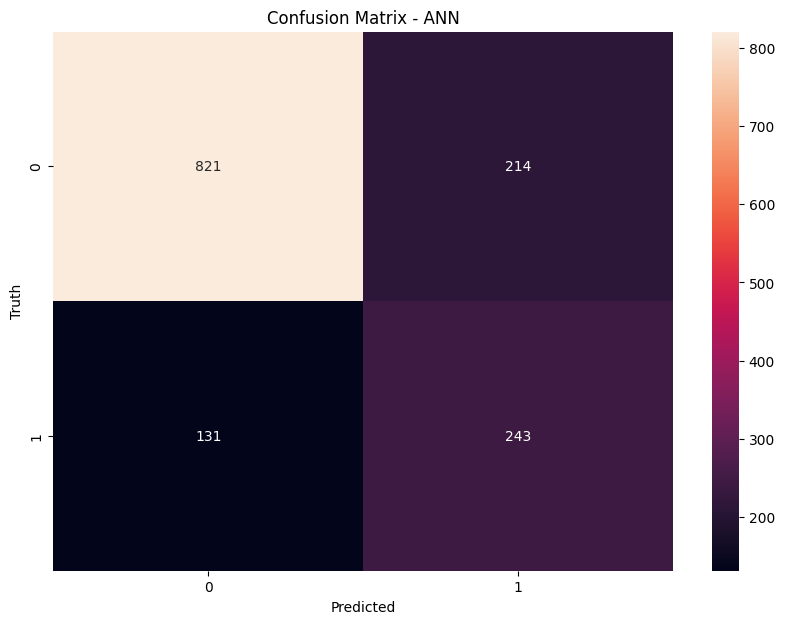

In [18]:
yp = model_ann.predict(X_test)
y_pred_ann = [1 if element > 0.5 else 0 for element in yp]

cm_ann = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 7))
sn.heatmap(cm_ann, annot=True, fmt='d')
plt.title("Confusion Matrix - ANN")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**Confusion Matrix Visualization for XGBoost**

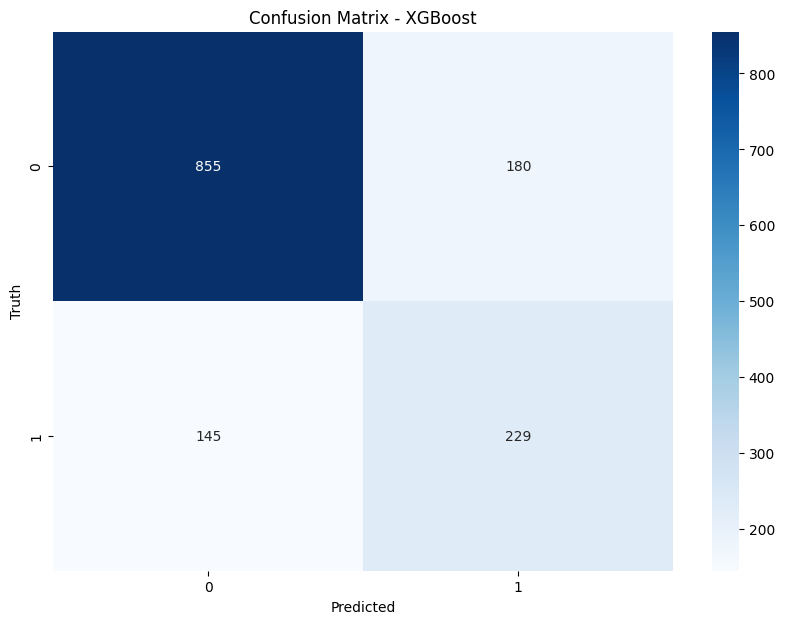

In [19]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 7))
sn.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Classification Reports


In [20]:
print("ANN Classification Report:")
print(classification_report(y_test, y_pred_ann))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

ANN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1035
           1       0.53      0.65      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.61      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409

